## CHAPTER 8 Dimensionality Reduction

许多机器学习问题的每个训练实例涉及数千甚至数百万的特征。正如我们将要看到的，这不仅使训练变得非常缓慢，而且还可能使得找到一个好的解决方案变得更加困难。这个问题通常被称为**维度的诅咒**。

幸好，在现实世界的问题中，通常可以大大减少特征的数量，将棘手的问题变成易处理的问题。
* 例如，考虑MNIST图像（在第3章中介绍）：图像边框上的像素几乎总是白色，因此您可以从训练集中完全丢弃这些像素而不会丢失太多信息。图7-6证实了这些像素对于分类任务完全不重要。 
* 此外，两个相邻像素通常高度相关：如果将它们合并为单个像素（例如，通过取两个像素强度的平均值），您将不会丢失太多信息
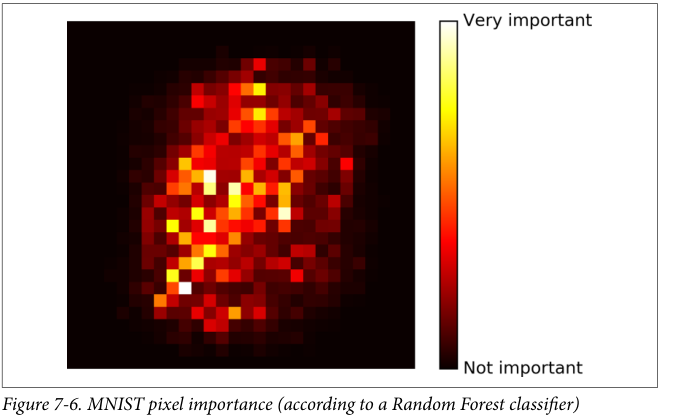

**降维**确实会丢失一些信息（就像将图像压缩为JPEG会降低其质量一样），因此即使它会加快训练速度，也可能会使你的系统性能稍差。 它还使你的管道更复杂，因此更难维护。 因此，如果训练速度太慢，你应
* 首先尝试使用原始数据训练你的系统，
* 然后再考虑使用降维。 

但是，在某些情况下，减少训练数据的维数可以过滤掉一些噪音和不必要的细节，从而导致更好的性能（但一般情况下它不会;它只会加速训练）。

除了加速训练，降维**对于数据可视化**（或DataViz）也非常有用。将维数减少到两（或三）可以在图上绘制高维训练集，并且通过视觉检测模式（例如聚类）获得一些重要的见解。

在这一章当中我们将讨论维度的诅咒，并了解高维空间中发生的事情。然后，我们将介绍降维的两种主要方法（**投影和流形学习-projection and Manifold Learning**），我们将介绍三种最流行的降维技术：**PCA，Kernel PCA和LLE**。

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "08_ Dimensionality Reduction -- unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

### 8.1 The Curse of Dimensionality

我们习惯于三维生活当我们试图想象一个高维空间时，我们的直觉会使我们感到失望。即使是基本的4D超立方体也难以想象（见图8-1），更不用说在1000维空间中弯曲的200维椭球体。
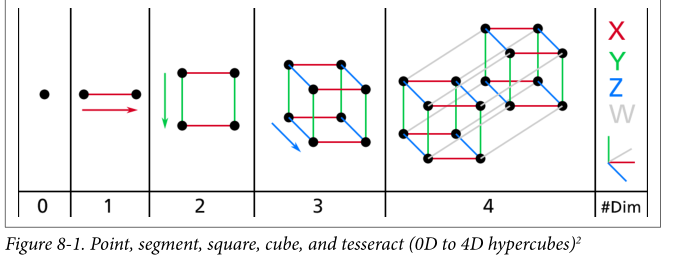

事实证明，许多事物在高维空间中表现得非常不同。例如，如果您选择单位平方（1×1平方）的随机点，它只有0.4％的可能性位于距离边界小于0.001的位置（换句话说，随机点在任何维度上都不太可能“极端”。)但是在10,000维单元超立方体（1×1×⋯×1立方体，具有1万1个）中，这个概率大于99.999999％。 高维超立方体中的大多数点非常靠近边界。

这是一个更麻烦的区别：
* 如果你在**单位平方**中随机选取两个点，这两个点之间的距离平均约为**0.52**。
* 如果在**单位3D立方体**中选取两个随机点，则平均距离大约为**0.66**。

但是在1,000,000维超立方体中随机选取两个点呢？不管你信不信，平均距离大概是408.25（大约1,000,000 / 6）！这是违反直觉的：当两个点位于同一单位超立方体内时，两个点如何相距甚远？这一事实意味着高维数据集存在**非常稀疏**的风险：大多数训练实例可能彼此相距很远。当然，这也意味着新实例可能远离任何训练实例，使得预测比较低维度更不可靠，因为它们将基于更大的推断。简而言之，**训练集的维度越多，过拟合的风险就越大**
它。

理论上，维度诅咒的**一个解决方案**可以是**增加训练集的大小以达到足够密度的训练实例**。不幸的是，在实践中，达到给定密度所需的**训练实例的数量随着维度的数量呈指数增长**。只有100个特征（远少于MNIST问题），你需要比宇宙中可观察的原子更多的训练实例，以便训练实例平均在0.1之内，假设它们在所有维度上均匀分布。

### 8.2 Main Approaches for Dimensionality Reduction

在我们深入研究特定降维算法之前，让我们来看看降维的两种主要方法：**投影和流形学习**。

#### 8.2.1 Projection

**投影**

在大多数现实问题中，训练实例并非在所有维度上均匀分布。 许多特征几乎不变，而其他特征则高度相关（正如之前为MNIST所讨论的那样）。因此，**所有训练实例实际上都在（或接近）很多高维空间的低维子空间**。这听起来非常抽象，所以让我们看一个例子。在图8-2中，你可以看到由圆圈表示的3D数据集。
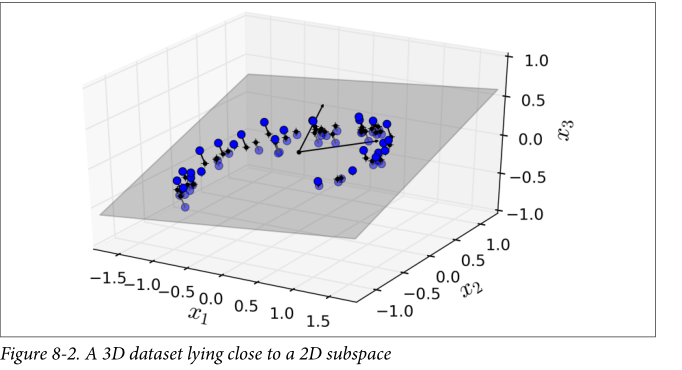

请注意，所有训练实例都靠近平面：这是高维（3D）空间的低维（2D）子空间。现在，如果我们将每个训练实例**垂直投影**到该子空间上（由将实例连接到平面的短线表示），我们得到了新的2D数据集，如图8-3所示.Ta-da！我们刚刚将数据集的维度**从3D缩小到2D**。请注意，轴对应于新特征$z_1$和$z_2$（平面上投影的坐标）。（3D时的特征是$x_1,x_2,x_3$）
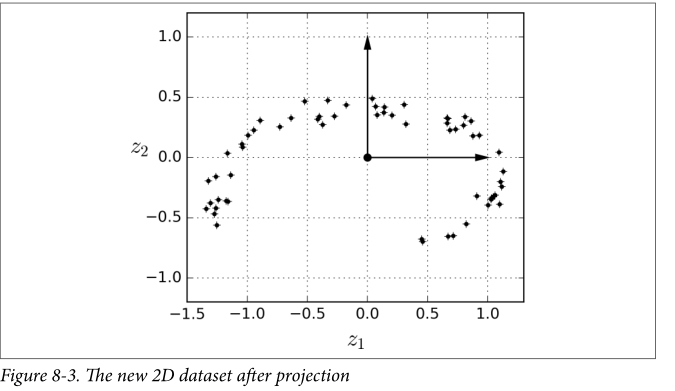

**但是**，投影并不总是减少维数的最佳方法。在许多情况下，子空间可能**扭曲和转动**，例如图8-4中所示的着名的**瑞士卷玩具数据集**。
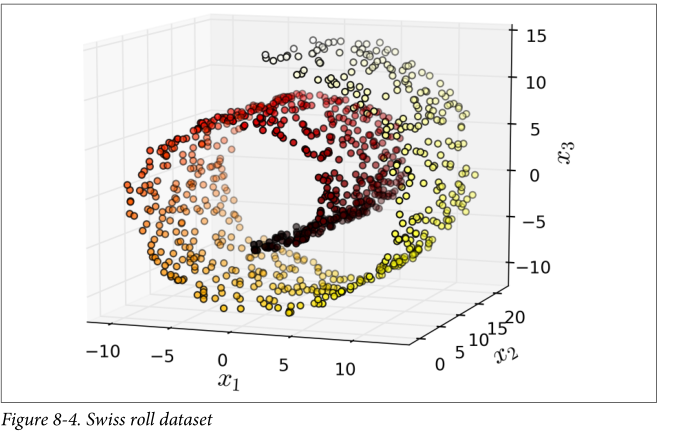

简单地投射到一个平面上（例如，通过去掉$x_3$）将瑞士卷的不同层压在一起，如图8-5左侧所示。但是，你真正想要的是展开Swiss卷以获取图8-5右侧的2D数据集。
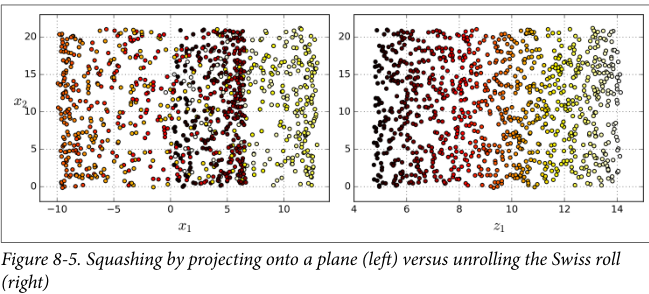

#### 8.2.2 Manifold Learning

瑞士卷是**2D流形**的一个例子。简而言之，2D流形是2D形状，可以在更高维空间中弯曲和扭曲。更一般地，**d 维流形**是n维空间的一部分（其中$d <n$），其局部类似于d维超平面。在瑞士卷的情况下，d = 2且 n = 3：它局部类似于2D平面，但它在第三维中滚动。

许多降维算法都通过对训练实例所在的流形进行建模来工作;这称为**流形学习**。它依赖于多重假设，也称为**流形假设**，它认为**大多数现实世界的高维数据集都靠近低得多的多维数据集**。可以经常观察到这种假设。

再一次，想想MNIST数据集：所有手写数字图像都有一些相似之处。它们由连线组成，边框为白色，他们或多或少地集中在一起，等等。如果你随机生成图像，只有一小部分图像看起来像手写数字。换句话说，如果您**尝试创建数字图像**，则**可用的自由度远低于允许生成任何所需图像时的自由度**。这些约束倾向于将数据集挤压到较低维度的流形中。


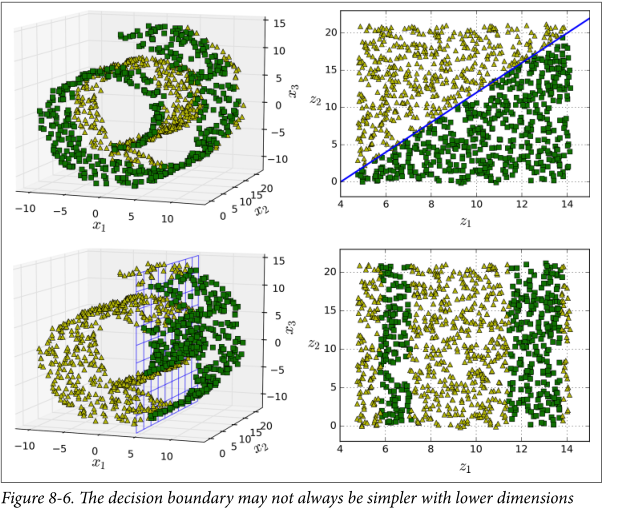


**流形假设通常伴随着另一个隐含的假设**：如果在流形的**低维空间**中表达，则我们手上的任务（例如，分类或回归）将更简单。例如，在图8-6的顶行中，瑞士卷被分为两类：在3D空间（左侧）中，决策边界相当复杂，但在2D展开的流形空间中（在右侧） ），决策边界是一条简单的直线。

但是，这种假设并不总是成立。例如，在图8-6的底行中，决策边界位于$x_1 = 5 $.此决策边界在原始3D空间（垂直平面）中看起来非常简单，但在展开的流形中看起来更复杂（四个独立线段的集合）。

简而言之，如果你**在训练模型之前减少训练集的维度，它肯定会加快训练速度**，但它可能并不总是能带来更好或更简单的解决方案;**这一切都取决于数据集**。

希望你现在对维度的诅咒有一个很好的认识以及降维算法如何对抗它，特别是当流形假设成立时。本章的其余部分将介绍一些最流行的算法。

### 8.3 PCA

**主成分分析（PCA）**是目前最受欢迎的降维算法。 首先，**它识别最接近数据的超平面**，然后**将数据投射到其上**。

#### 8.3.1 Preserving the Variance

**保留方差**

在将训练集投影到低维超平面之前，你**首先需要选择合适的超平面**。 例如，图8-7左侧表示一个简单的2D数据集，以及三个不同的轴（即，一维超平面）。
右侧是数据集投影到每个轴上的结果。如你所见，

* 实线上的投影保留了最大方差，（上面）
* 点虚线上的投影保留了非常小的方差，（下面）
* 点横虚线上的投影保留了中间量的方差。（中间）

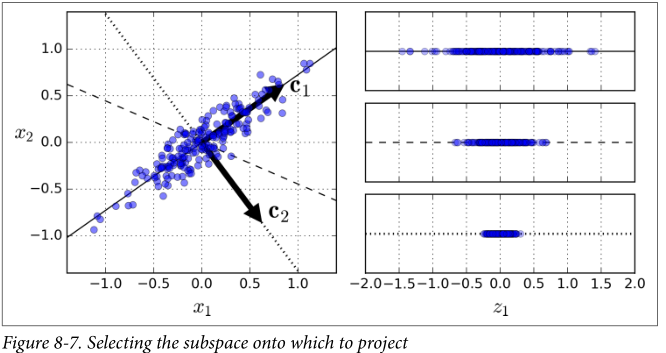

选择**保留最大方差的轴**似乎是合理的，**因为**它很可能比其他预测损失更少的信息。**另一种证明这种选择**的方法是它是最小化原始数据集与其在该轴上的投影之间的均方距离的轴。这是PCA背后相当简单的想法。

#### 8.3.2 Principal Components

**主成分**  

PCA识别在训练集中占最大方差量的轴。在图8-7中，它是实线。 它还找到与第一个轴正交的第二个轴，它考虑了剩余方差的最大量。在这个2D示例中，没有选择：它是虚线。**如果它是一个更高维的数据集，PCA还会找到与前两个轴正交的第三个轴，以及第四个，第五个等等 - 与数据集中的维数一样多的轴**。

定义第 $i$ 轴的**单位矢量**称为第 $i$ 个**主成分 (PC)**  。

* 在图8-7中，第一个 **PC**为 $c_1$，第二个 **PC** 为 $c_2$ 。

* 在图8-2中，前两个 **PC**由平面中的正交箭头表示，第三个 **PC**与平面正交（向上或向下）。

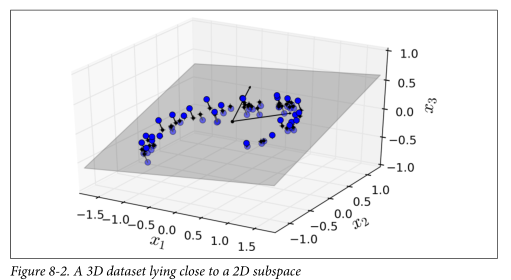

主成分的方向不是稳定：如果你稍微扰乱训练集并再次运行PCA，一些新PC可能指向与原始PC相反的方向。但是，它们通常仍然位于相同的轴上。 在某些情况下，一对PC甚至可以旋转或交换，但它们定义的平面通常保持不变。

那么**如何找到训练集的主要组成部分呢？**幸运的是，有一种称为**奇异值分解（SVD）**的标准矩阵分解技术可以将训练集矩阵 $X$ 分解为**三个矩阵 $ U·Σ·V^T$ 的点积**，其中 $V^T$ 包含我们正在寻找的所有主成分， 如公式8-1所示。
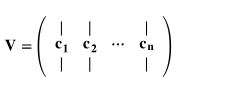

以下Python代码使用NumPy的**svd（）函数** 获取训练集的所有主成分，然后提取前两个PC； **svd() 函数返回** $ U, s ,Vt $, 其中 $Vt$ 等于 
$ V^T $, 是矩阵 $V$的转置. 

Build 3D dataset:

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

**PCA using SVD decomposition**

In [3]:
X_centered = X-X.mean(axis=0)
U,s,Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

In [4]:
m,n = X.shape

S = np.zeros(X_centered.shape)
S[:n,:n] = np.diag(s)

np.allclose(X_centered,U.dot(S).dot(Vt))

True

**PCA假定数据集以原点为中心**。 我们会看到，Scikit-Learn的PCA类负责为你处理数据中心化。 **但是**，如果你要自己实现PCA（如前面的示例所示），或者如果你使用其他库，请不要忘记**首先将数据居中**。

#### 8.3.3 Projecting Down to d Dimensions

一旦确定了所有主成分，你可以通过**将数据集投影到由前d个主成分定义的超平面上，将数据集的维数降低到d维**。选择此超平面可确保投影尽可能保留方差。例如，在图8-2中，3D数据集向下投影到由前两个主成分定义的2D平面，保留了数据集方差的很大一部分。因此，2D投影看起来非常像原始3D数据集。

要将训练集投影到超平面上，你可以通过矩阵 $W_d$ 简单地计算训练集矩阵$X$的点积，矩阵 $W_d$ 定义为包含前 d 个主成分的矩阵（即，由$ V$的前d列组成的矩阵），如公式8-2所示。
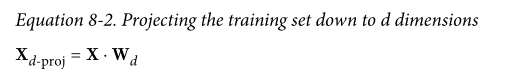

以下Python代码将训练集投影到由前两个主成分定义的平面上：

In [5]:
W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)

In [6]:
X2D_using_svd = X2D

你现在知道如何将任何数据集的维度降低到任意数量的维度，同时保留尽可能多的方差。

#### 8.3.4 Using Scikit-Learn

Scikit-Learn的**PCA类使用SVD分解实现PCA**，就像我们一样前面做的一样。以下代码**应用PCA**将数据集的维度降低到二维（请注意，它会自动处理数据居中）：

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [8]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [9]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

在数据集上实现PCA之后后，你可以使用**components_ ** 变量访问主成分（请注意，它包含PC作为水平向量，因此，例如，第一个主成分等于pca.components_.T [：，0]）。

请注意，在略有不同的数据集上多次运行PCA可能会导致不同的结果。 通常，唯一的区别是可能会翻转某些轴。在这个例子中，使用Scikit-Learn的PCA提供与SVD方法相同的投影，除了两个轴都被翻转：

In [10]:
np.allclose(X2D,-X2D_using_svd)

True

恢复投影在平面上的3D点（PCA 2D子空间）。

In [11]:
X3D_inv = pca.inverse_transform(X2D)

当然，在投影步骤中有一些信息丢失，所以恢复的3D点并不完全等于原始的3D点：

In [12]:
np.allclose(X3D_inv,X)

False

我们可以计算重建误差：

In [13]:
np.mean(np.sum(np.square(X3D_inv - X),axis=1))

0.010170337792848549

SVD方法中的逆变换如下所示：

In [14]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2,:])

这两种方法的重建并不完全相同，因为Scikit-Learn的PCA类会自动处理反转平均居中的问题，但如果我们减去均值，我们得到相同的重建：

In [15]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

PCA对象对其计算的主成分提供的访问(access)：

In [16]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

与使用SVD方法计算的前两个主成分进行比较：

In [17]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

注意轴是如何翻转的。

#### 8.3.5 Explained Variance Ratio

另一个非常有用的信息是每个主成分的**解释方差比**，可通过**explain_variance_ratio_变量**获得。**它表示沿着每个主成分的轴的数据集方差的比例**。 例如，让我们看一下图8-2中表示的3D数据集的前两个主成分的解释方差比：

In [18]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

这告诉我们84.2％的数据集的方差位于第一个轴上，14.6％位于第二个轴。对于第三个轴，留下不到1.2％，因此可以合理地假设它可能携带很少的信息。

通过向下投影到2D，我们失去了大约4.9％的方差：

In [19]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

以下是如何使用SVD方法计算解释的方差比（回想一下s是矩阵S的对角线）：

In [20]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

从这里开始一直到8.3.6之前，主要做了两件事：

* 对**8.2 Main Approaches for Dimensionality Reduction**中：**投影和流形学习(Projection and Manifold Learning)** 出现的图片进行绘制

* 对**8.3.1 Preserving the Variance**中出现的图片进行绘制

用于绘制3D箭头的实用程序类(copied from http://stackoverflow.com/questions/11140163)

In [21]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

将平面表示为x和y的函数。

In [22]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

在该平面上绘制三维数据集，平面和投影。

Saving figure dataset_3d_plot


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\ML\\Machine learning\\Hands-on machine learning with scikit-learn and tensorflow\\images\\08_ Dimensionality Reduction -- unsupervised_learning\\dataset_3d_plot.png'

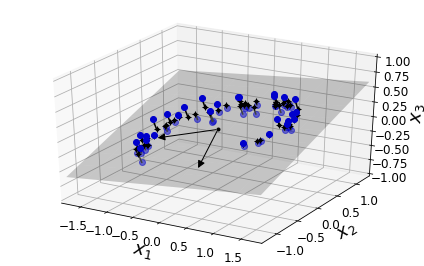

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("dataset_3d_plot")
plt.show()

Saving figure dataset_2d_plot


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\ML\\Machine learning\\Hands-on machine learning with scikit-learn and tensorflow\\images\\08_ Dimensionality Reduction -- unsupervised_learning\\dataset_2d_plot.png'

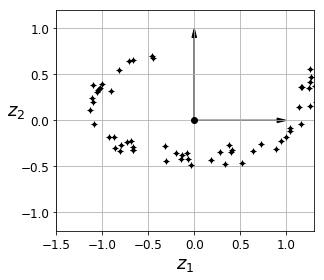

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

**Manifold learning**

Swiss roll:

In [25]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\ML\\Machine learning\\Hands-on machine learning with scikit-learn and tensorflow\\images\\08_ Dimensionality Reduction -- unsupervised_learning\\swiss_roll_plot.png'

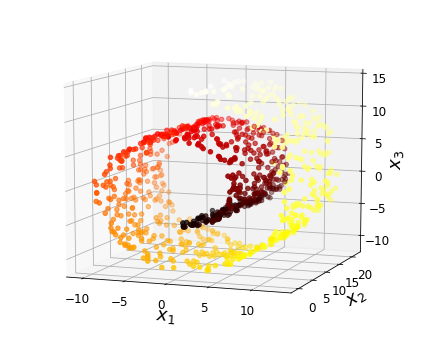

In [26]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

Saving figure squished_swiss_roll_plot


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\ML\\Machine learning\\Hands-on machine learning with scikit-learn and tensorflow\\images\\08_ Dimensionality Reduction -- unsupervised_learning\\squished_swiss_roll_plot.png'

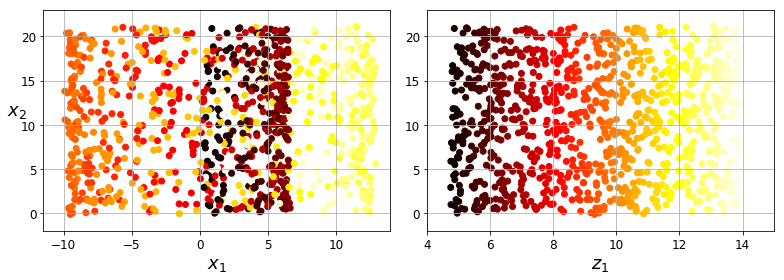

In [27]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

Saving figure manifold_decision_boundary_plot1


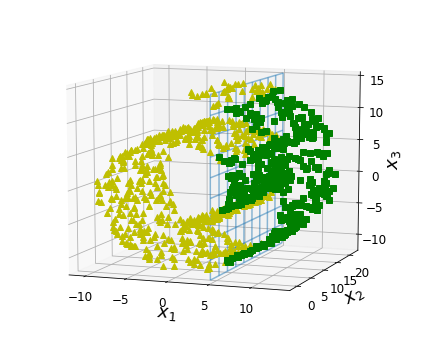

Saving figure manifold_decision_boundary_plot2


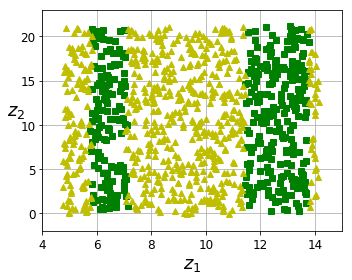

Saving figure manifold_decision_boundary_plot3


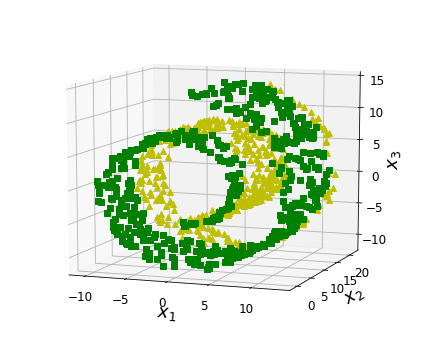

Saving figure manifold_decision_boundary_plot4


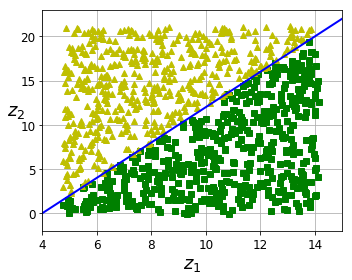

In [28]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

**PCA**

Saving figure pca_best_projection


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\ML\\Machine learning\\Hands-on machine learning with scikit-learn and tensorflow\\images\\08_ Dimensionality Reduction -- unsupervised_learning\\pca_best_projection.png'

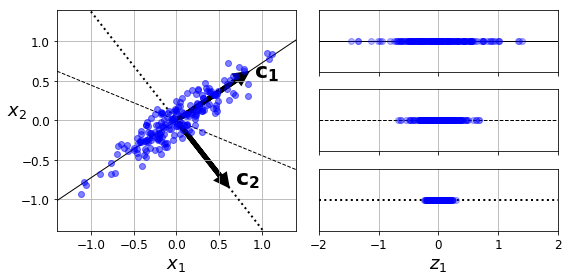

In [28]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection")
plt.show()

#### 8.3.6 Choosing the Right Number of Dimensions

通常倾向于选择方差部分加起来足够大的维数（例如，95％），而不是随意选择要减少的维数。当然，除非你正在减少数据可视化的维度 - 在这种情况下，你通常希望将维度降低到2或3。

以下代码在不降低维度的情况下计算PCA，然后计算保留95％训练集方差所需的最小维数：

In [29]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)+1

然后，你可以设置**n_components = d**并再次运行PCA。但是，有一个更好的选择：你可以将**n_components设置为介于0.0和1.0**之间的浮点数，而不是指定要保留的主成分的数量，这表示你希望保留的**方差比**：

In [30]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

还有一种选择是将解释方差比作为维数的函数进行绘图（简单绘制cumsum;见图8-8）。曲线中通常会有拐点，这是需要解释方差比停止快速增长的地方。 你可以将此视为数据集的内在维度。在这种情况下，你可以看到将维度降低到大约100维不会失去太多解释方差比。
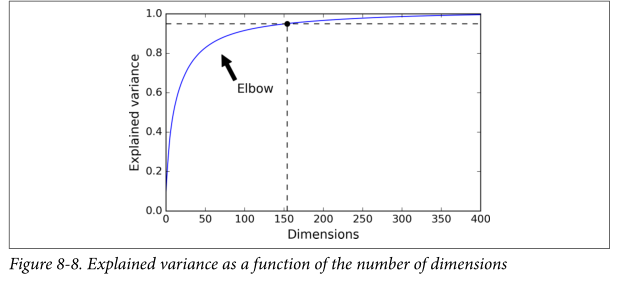

#### 8.3.7 PCA for Compression

显然，在减少维数后，训练集占用的空间更少。例如，尝试将PCA应用于MNIST数据集同时保留95％的方差。你应该会发现每个实例只有150多个特征，而不是原始的784个特征。因此，虽然保留了大部分方差，但数据集现在还不到其原始大小的20％！这是一个合理的压缩比，你可以看到它如何极大地加速分类算法（如SVM分类器）。


通过应用PCA投影的逆变换将缩小的数据集解压缩回784维也是可能的。当然，这不会还给你原始数据，因为投影丢失了一些信息（在丢弃的5％方差内），但它可能非常接近原始数据。**原始数据和重建数据之间的均方距离（压缩然后解压缩）称为重建错误**。

例如，以下代码将MNIST数据集**压缩**到154维，然后使用**inverse_transform（）**方法将其**解压缩**回784维。图8-9显示了原始训练集（左侧）的几位数字，以及压缩和解压缩后的相应数字。你可以看到图像质量略有下降，但数字仍然大部分完好无损。

**MNIST compression**

In [31]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


HTTPError: HTTP Error 500: Internal Privoxy Error

In [33]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

NameError: name 'mnist' is not defined

In [32]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(d)

NameError: name 'X_train' is not defined

In [35]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [36]:
pca.n_components_

154

In [37]:
np.sum(pca.explained_variance_ratio_)

0.9503623084769203

In [38]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [39]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


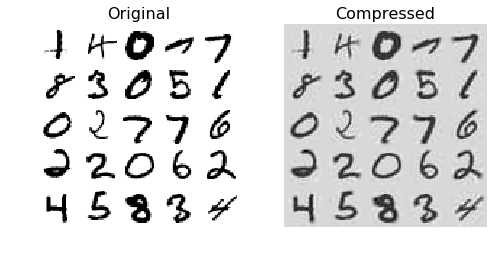

In [40]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [41]:
X_reduced_pca = X_reduced

逆变换的等式如等式8-3所示:
  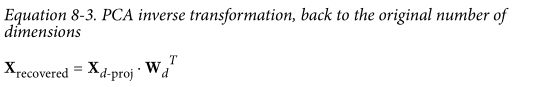  

#### 8.3.8 Incremental PCA

前面实现的PCA存在的一个问题是它需要整个训练集适合内存以便运行SVD算法。幸运的是，已经开发了**Incremental PCA (IPCA)** 算法：你可以将训练集分成小批量并一次提供给IPCA算法一个小批量。这对于大型训练集非常有用，并且也可以在线应用PCA（即，在运行中有新实例进来）。

以下代码将MNIST数据集拆分为100个小批量（使用NumPy的**array_split（）函数**）并将它们提供给Scikit-Learn的**IncrementalPCA class** ，以将MNIST数据集的维数降低到154维（就像以前那样）。请注意，对**每个小批量**你必须调用**partial_fit（）方法**而不是对**整个训练集**调用**fit（）方法**：

In [42]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train,n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [43]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

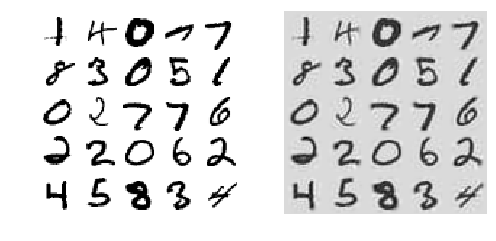

In [44]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [45]:
X_reduced_inc_pca = X_reduced

让我们比较使用regular PCA and incremental PCA转换MNIST的结果。 首先，均值是平等的：

In [46]:
np.allclose(pca.mean_, inc_pca.mean_)

True

但结果并不完全相同。 增量PCA提供了一个非常好的近似解决方案，但它并不完美：

In [47]:
np.allclose(X_reduced_pca,X_reduced_inc_pca)

False

或者，你可以使用NumPy的**memmap**类，它允许你操作存储在磁盘上的二进制文件中的大型数组，就好像它完全在内存中一样;该类在需要时仅加载内存中所需的数据。由于IncrementalPCA类在任何给定时间仅使用数组的一小部分，因此内存使用仍然受到控制。这使得可以调用通常的**fit（）方法**，如下面的代码所示：

让我们创建memmap（）结构并将MNIST数据复制到其中。 这通常由第一个程序完成：

In [48]:
filename = "my_mnist.data"
m,n = X_train.shape

X_mm = np.memmap(filename,dtype = 'float32',mode='write',shape=(m,n))
X_mm[:] = X_train

现在删除memmap（）对象将触发其Python终结器，确保将数据保存到磁盘。

In [49]:
del X_mm

接下来，另一个程序将加载数据并将其用于训练：

In [50]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

#### 8.3.9 Randomized PCA

Scikit-Learn提供了另一种执行PCA的选项，称为**随机PCA(Randomized PCA)** 。这是一种随机算法，可快速找到前d个主成分的近似值。其计算复杂度为$O(m×d^2)+ O(d^3)$，而不是 $O(m×n^2)+O(n^3) $，所以当d远小于n时，它比以前的算法快得多。

In [51]:
rnd_pca = PCA(n_components=154,svd_solver = "randomized",random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### 8.4 Kernel PCA

在第5章中我们讨论了**核技巧**，一种数学技术，它将实例隐式映射到一个非常高维的空间（称为**特征空间**），通过支持向量机实现非线性分类和回归。回想一下，高维特征空间中的线性决策边界对应于**原始空间**中的复杂非线性决策边界。

事实证明，同样的技巧可以应用于PCA，使得有可能**执行复杂的非线性投影以减少维数**。这称为**核PCA（kPCA）**。 核PCA通常擅长在投影后保留实例簇，或者有时甚至展开靠近扭曲流形的数据集。

例如，以下代码使用Scikit-Learn的**KernelPCA类**来执行带有RBF内核的kPCA（有关RBF内核和其他内核的更多详细信息，请参阅第5章）：

In [57]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [58]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


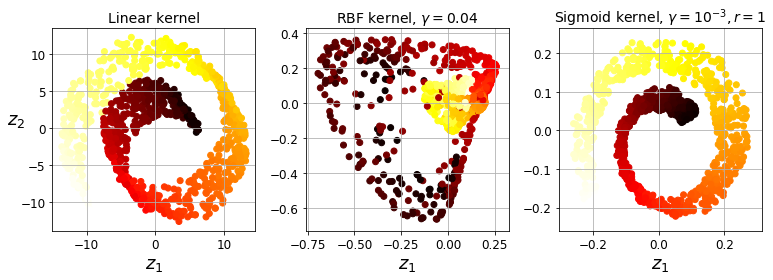

In [59]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

图8-10（即上图）显示了瑞士卷，使用线性内核减少到二维（相当于简单地使用PCA类），一个RBF内核和一个sigmoid内核（Logistic）。

Saving figure preimage_plot


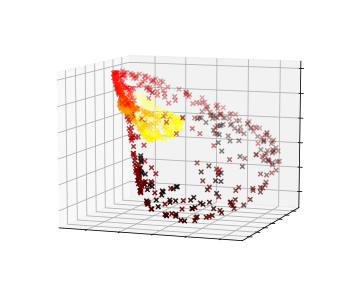

In [60]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

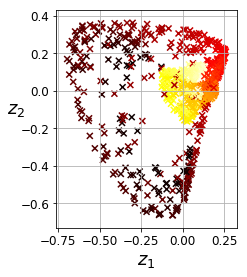

In [61]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

#### 8.4.1 Selecting a Kernel and Tuning Hyperparameters

由于**kPCA是一种无监督学习算法**，没有明显的性能指标来帮助您选择最佳内核和超参数值。但是，**降维通常是监督学习任务（例如，分类）的准备步骤**，因此你可以简单地使用**网格搜索**来选择使该任务具有最佳性能的内核和超参数。
例如，以下代码创建了一个两步管道，

* 首先使用kPCA将维度降低到两个维度，

* 然后应用Logistic回归进行分类。 

* 最后，它使用**Grid SearchCV**为kPCA找到最佳内核和gamma值，以便在管道末端获得最佳分类准确度：

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\lo

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\lo

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRe...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

然后可以通过**best_params_变量**获得最好的内核和超参数：

In [69]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


**另一种方法**，是**选择产生最低重建误差的内核和超参数**,这种方法完全没有监督。然而，**重建并不像线性PCA那么容易**。这就是原因。图8-11显示了原始Swiss roll 3D数据集（左上角），以及使用RBF内核（右上角）应用kPCA后生成的2D数据集。由于核技巧，这在数学上等效于使用特征映射$φ$将训练集映射到无限维特征空间（右下），然后使用线性PCA将变换后的训练集投影到2D。

注意，**如果我们可以在缩小的空间中反转给定实例的线性PCA步骤，则重建的点将位于特征空间中，而不是在原始空间中**（例如，类似于图中的 x 所表示的那个）。由于特征空间是无限维的，我们无法计算重建点，因此我们无法计算真正的重建误差。幸运的是，**有可能在原始空间中找到一个靠近重建点的点**。这称为**reconstruction pre-image**。获得此pre-image后，你可以测量与原始实例的平方距离。然后，你可以选择最小化此**reconstruction pre-image**误差的内核和超参数。

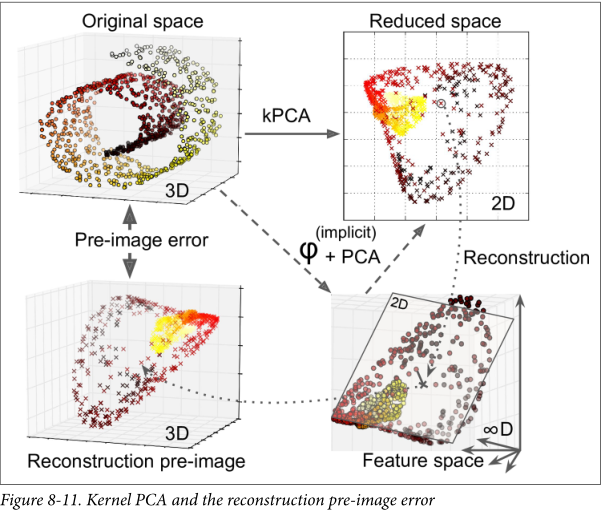

你可能想知道如何执行此重建。**一种解决方案是训练监督回归模型**，

* 将预测实例作为训练集，
* 将原始实例作为目标。

如果设置**fit_inverse_transform = True**，Scikit-Learn将自动执行此操作，如以下代码所示：

In [71]:
rbf_pca = KernelPCA(n_components =2,kernel="rbf",gamma=0.0433,
                   fit_inverse_transform=True)

X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

默认情况下，fit_inverse_transform = False，而**KernelPCA**没有inverse_transform（）方法。 只有在设置fit_inverse_transform = True时才会创建此方法

然后你就可以计算**reconstruction pre-image**误差了：

In [72]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766125

现在，你可以使用带有**交叉验证**的**网格搜索**来查找可最大限度地减少此前**reconstruction pre-image**的内核和超参数了。

### 8.5 LLE

**局部线性嵌入-Locally Linear Embedding**（LLE）是另一种非常强大的**非线性降维（NLDR）技术**。**它是一种流形学习技术**，不依赖于先前算法的预测。简而言之，LLE的**工作原理**是:

* 首先测量每个训练实例如何与其最近邻居(c.n.)线性相关，

* 然后寻找训练集的低维表示，其中这些局部关系得到最好的保留（更多细节）。

这使得它特别擅长展开扭曲的流形，特别是在没有太多噪音的情况下。

例如，以下代码使用Scikit-Learn的**LocallyLinearEmbedding类**来展开Swiss roll。生成的2D数据集如图8-12所示。如你所见，瑞士卷完全展开，实例之间的距离被局部保留。但是，距离不能保持在更大的范围内：**展开的瑞士卷的左侧部分被挤压，而右侧部分被拉伸**。尽管如此，LLE在流形建模方面做得相当不错。

In [73]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [74]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


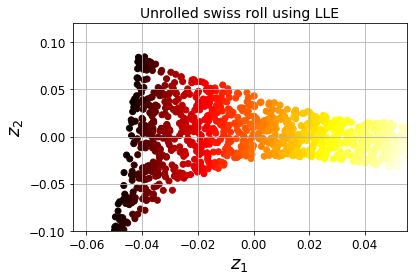

In [75]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

以下是LLE的工作原理：

首先，对于每个训练实例$x(i)$，算法识别其 $k$ 个最近邻居（在前面的代码中$k = 10$），然后尝试将$x(i)$重建为这些邻居的线性函数。

更具体地，它找到权重$w_{i,j}$，使得 $x(i)$ 和 $Σ_{j=1}^m  w_{i,j} x^{(j)}$之间的平方距离尽可能小，
如果$x(j)$不是$x(i)$的$k$个最近邻居之一,则假设$w = 0$。

因此，LLE的**第一步**是公式8-4中描述的约束优化问题，其中$W$是包含所有权重$w_{i,j}$的权重矩阵。 第二个约束简单地标准化每个训练实例$x(i)$的权重。

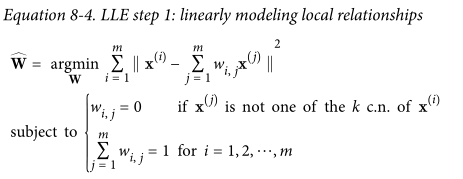

这一步之后，权重矩阵$W$（包含权重$w_(i,j)$）编码训练实例之间的局部线性关系。**第二步**是将训练实例映射到 $d$ 维空间（其中$d < n$），同时尽可能保留这些局部关系。如果$z(i)$是该 $d$ 维空间中的 $x(i)$ 的图像，则我们希望 $z(i)$ 和 $Σ_{j=1}^m  w_{i,j} z^{(j)}$之间的平方距离尽可能小。

这个想法导致了公式8-5中描述的无约束优化问题。 它看起来与第一步非常相似，但不是保持实例固定并找到最佳权重，而是反过来：**保持权重固定并在低维空间中找到实例图像的最佳位置**。 注意 $Z$ 是包含所有 $z(i)$ 的矩阵

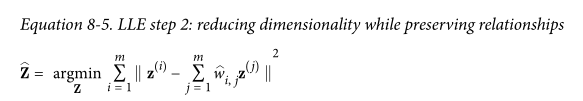


Scikit-Learn的LLE实现具有以下计算复杂度：
* $O(m log(m)nlog(k))$ 用于求 $k$ 个最近邻，
* $O(mnk^3)$ 用于优化权重
* $O(dm^2)$ 用于构造低维表示。

不幸的是，最后一个术语中的 $m^2$ 使得该算法在非常大的数据集上**scale poorly**。

### 8.6 Other Dimensionality Reduction Techniques

还有许多其他降维技术，Scikit-Learn中有几种可用。以下是一些最受欢迎的：

• **多维缩放- Multidimensional Scaling(MDS)**在尝试保留实例之间的距离时降低了维度（见图8-13）。

• **Isomap**通过将每个实例连接到最近的邻居来创建图形，然后在尝试保持实例之间的测地距离时降低维数。

• **t分布随机邻域嵌入- t-Distributed Stochastic Neighbor Embedding (t-SNE)** 降低了维数同时试图让类似的实例保持接近，并将不同的实例分开。它主要用于可视化，特别地，可视化高维空间中的实例簇（例如，以2D形式显示MNIST图像）。

• **线性判别分析- Linear Discriminant Analysis（LDA）**实际上是一种分类算法，但是在训练期间，它会学习类之间最具辨别力的轴，然后可以使用这些轴来定义投影数据的超平面。**好处是投影将使类与类尽可能远离，所以在运行另一种分类算法（如SVM分类器）之前，LDA是一种降低维数的好方法**。

In [76]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [77]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [78]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Saving figure other_dim_reduction_plot


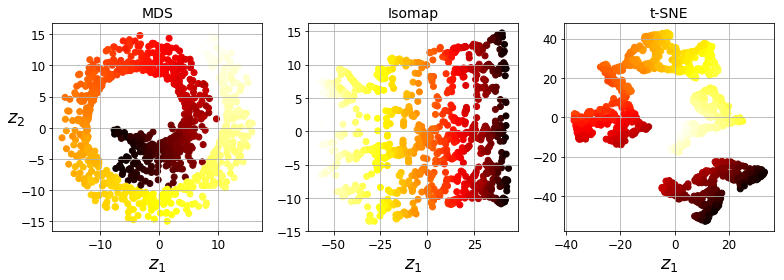

In [80]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

In [81]:
def learned_parameters(model):
    return [m for m in dir(model)
            if m.endswith("_") and not m.startswith("_")]

In [ ]:
## 9. Extra Material – Clustering

In [ ]:
### 9.1 

In [ ]:
### 9.2 